In [1]:
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, inspect

In [3]:
#create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
#create inspector
inspector = inspect(engine)

In [5]:
#look at tables
inspector.get_table_names()

['measurement', 'station']

In [6]:
# write the query for measurement table
query_m = """
        SELECT * 
        FROM measurement
        """
#create connection and bring back dataframe

conn = engine.connect()

measurement = pd.read_sql(query_m, conn)
measurement

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [7]:
#second query 
query_s = """
            SELECT * 
            FROM station
            """
# bring back dataframe
station = pd.read_sql(query_s,conn)
station.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

In [8]:
#find max date for measurement
measurement.date.max()

'2017-08-23'

In [9]:
#query for last 12 months of precipitation data

query_twelve = """
                SELECT
                    date, 
                    prcp
                FROM measurement
                WHERE date > DATE('2017-08-23', '-12 months')
                """

twelve = pd.read_sql(query_twelve, conn)
rain = twelve.set_index('date').sort_values('date')
rain.index = pd.to_datetime(rain.index)
rain.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


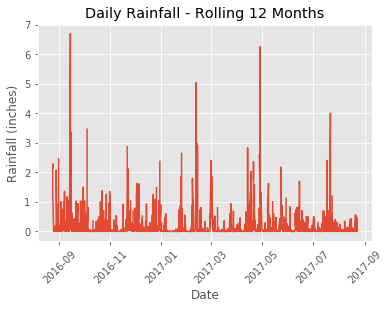

In [10]:
#plot daily rainfall totals
plt.plot(rain.index, rain.values)
plt.title('Daily Rainfall - Rolling 12 Months')
plt.xlabel('Date')
plt.ylabel('Rainfall (inches)')
plt.xticks(rotation = 45)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
#using pandas 
len(station.station.value_counts())

9

In [13]:
#Using a query 

query_count = """
            SELECT 
                COUNT(station)
            FROM station
            """
count = pd.read_sql(query_count, conn)
count

,COUNT(station)
0,9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order - with pandas
measurement.station.value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [15]:
#now with SQL/query
query_max = """
            SELECT
                station, 
                COUNT(station) as Frequency
            FROM measurement 
            GROUP BY station
            ORDER BY Frequency DESC
            """

maximum = pd.read_sql(query_max, conn)
maximum

,station,Frequency
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

query_stats = """
            SELECT 
                MIN(tobs) as min_temp, 
                MAX(tobs) as max_temp, 
                AVG(tobs) as avg_temp
            FROM measurement
            WHERE station = 'USC00519281'
            """

stats = pd.read_sql(query_stats, conn)
stats

,min_temp,max_temp,avg_temp
0,54.0,85.0,71.663781


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_temp = """
            SELECT 
                date,
                tobs as Temperature
            FROM measurement
            WHERE 
                station = 'USC00519281' AND 
                date > DATE('2017-08-23', '-12 months')
            """
temp = pd.read_sql(query_temp, conn)
temp

,date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


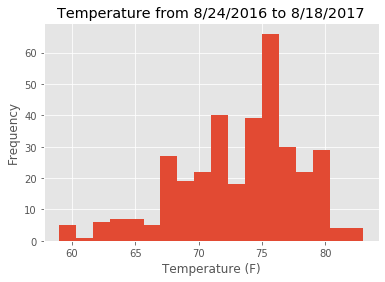

In [18]:
plt.hist(temp.Temperature, bins = 18)
plt.title('Temperature from 8/24/2016 to 8/18/2017')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.show()

## Figuring Out Part Two

In [19]:
query_rand ="""
            SELECT 
                MIN(tobs) as min_temp, 
                MAX(tobs) as max_temp, 
                AVG(tobs) as avg_temp
            FROM measurement 
            WHERE 
                date < '2017-08-23'
                AND 
                date > '2016-08-23'
                """

In [20]:
conn = engine.connect()
rand = pd.read_sql(query_rand,conn)

In [21]:
rand

,min_temp,max_temp,avg_temp
0,58.0,87.0,74.568725


In [22]:
def dates (start_date = '2010-01-01', end_date = '2017-08-23'):
        query5 = f"""
                    SELECT * 
                    FROM measurement 
                """
        conn5 = engine.connect()
        df5 = pd.read_sql(query5,conn5)
        conn5.close()
        date_mask = (df5.date >= start_date)  & (df5.date <= end_date)
        sorted_df = df5.loc[date_mask]
        mt = sorted_df.tobs.max()
        at = sorted_df.tobs.mean()
        mint = sorted_df.tobs.min()
        new = pd.DataFrame([mt,at,mint])
        new = new.rename(index = {0:'Max_Temp', 1:'Avg Temp', 2:'Min Temp'}, columns = {0:'Temperature (F)'})
        return new

In [23]:
dates()

,Temperature (F)
Max_Temp,87.000000
Avg Temp,73.097954
Min Temp,53.000000


In [25]:
#close the connection 
conn.close()